# Medical Image Classification

**Company Use Case:**


**Approach:**



The following Notebook will show two approaches to do this with ConcreteML.

**Dataset Information:**

_Dataset  1:_

<span style="color:yellow">description</span>

**Dataset Source:**

https://medmnist.com/

Dataset 1:

https://github.com/logpai/loghub/blob/master/Android/Android_2k.log_structured.csv

# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# MedMNIST
import medmnist

# SciKit-Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

# PyTorch
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision.models import resnet50, vgg16
from torchsummary import summary

In [2]:
# # set random seed
np.random.seed(1)
torch.manual_seed(1)

# General Functions

In [3]:
###############################################################
# Logging
###############################################################

def log_parameters():
    if os.path.isfile(f'{dataset}_Experiments.csv'):
        df = pd.read_csv(f'{dataset}_Experiments.csv')
        df = df.drop_duplicates()
        # append new row
        df = pd.concat([df, pd.DataFrame({
            'epochs': [epochs],
            'learning_rate': [learning_rate],
            'weight_decay': [weight_decay],
            'model': [str(model)],
            'final_train_loss': [train_losses[-1]],
            'final_train_accuracy': [train_accuracies[-1]],
            'final_val_loss': [val_losses[-1]],
            'final_val_accuracy': [val_accuracies[-1]]
            })])
        # save csv
        df.to_csv(f'{dataset}_Experiments.csv', index=False)

    else:
        df = pd.DataFrame({
        'epochs': [epochs],
        'learning_rate': [learning_rate],
        'weight_decay': [weight_decay],
        'model': [str(model)],
        'final_train_loss': [train_losses[-1]],
        'final_train_accuracy': [train_accuracies[-1]],
        'final_val_loss': [val_losses[-1]],
        'final_val_accuracy': [val_accuracies[-1]]
        })
        # save csv
        df.to_csv(f'{dataset}_Experiments.csv', index=False)
    
    return 'Parameters Logged!'

# Load Data

In [4]:
dataset = 'OCTMNIST'
# dataset = 'PneumoniaMNIST'

# initialize DataClass
DataClass = getattr(medmnist, dataset)

# download data
train_dataset = DataClass(split='train',download=True)
eval_dataset = DataClass(split='val', download=True)
test_dataset = DataClass(split='test', download=True)

# print infos
print(f'\n{train_dataset}')

Using downloaded and verified file: /home/lukas/.medmnist/octmnist.npz
Using downloaded and verified file: /home/lukas/.medmnist/octmnist.npz
Using downloaded and verified file: /home/lukas/.medmnist/octmnist.npz

Dataset OCTMNIST (octmnist)
    Number of datapoints: 97477
    Root location: /home/lukas/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'choroidal neovascularization', '1': 'diabetic macular edema', '2': 'drusen', '3': 'normal'}
    Number of samples: {'train': 97477, 'val': 10832, 'test': 1000}
    Description: The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (

In [5]:
# data to numpy
xtrain, ytrain = train_dataset.imgs, train_dataset.labels
xval, yval = eval_dataset.imgs, eval_dataset.labels
xtest, ytest = test_dataset.imgs, test_dataset.labels

# filter data to binary classification
# class 0 & class 1
if len(np.unique(ytrain.flatten())) > 2:
    xtrain, ytrain = xtrain[ytrain.flatten()<2], ytrain[ytrain.flatten()<2]
    xval, yval = xval[yval.flatten()<2], yval[yval.flatten()<2]
    xtest, ytest = xtest[ytest.flatten()<2], ytest[ytest.flatten()<2]

# expand dimension (grayscale)
# (channels=1, height=28, width=28)
xtrain = np.expand_dims(xtrain, axis=1)
xval = np.expand_dims(xval, axis=1)
xtest = np.expand_dims(xtest, axis=1)

# expand dimension (rgb) - needed for pretrained models
# (channels=3, height=28, width=28)
xtrain_rgb = np.repeat(xtrain, 3, axis=1)
xval_rgb = np.repeat(xval, 3, axis=1)
xtest_rgb = np.repeat(xtest, 3, axis=1)

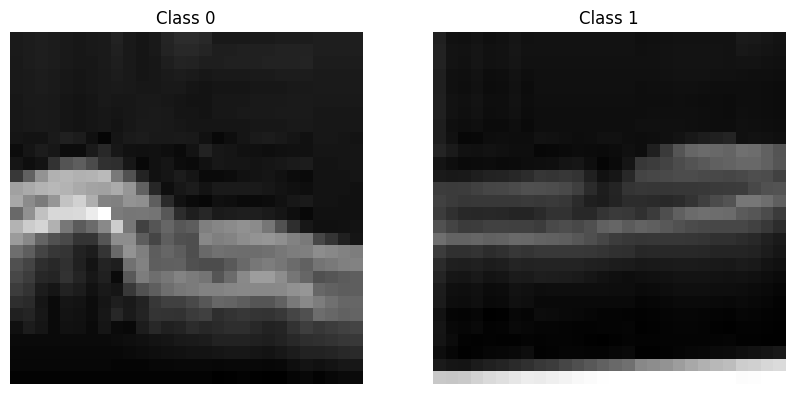

In [6]:
# plot sample images of each class
n_classes = len(np.unique(ytrain))

fig, ax = plt.subplots(nrows=1, ncols=n_classes, figsize=(10, 5))
for i in range(n_classes):
    ax[i].imshow(xtrain[ytrain.flatten()==i][0][0], cmap='gray')
    ax[i].set_title(f'Class {i}')
    ax[i].axis('off')

# Modelling

## Convolutional Neural Network

In [7]:
epochs = 30
learning_rate = 0.0001
weight_decay = 0.0001

In [8]:
xtrain_tensor, ytrain_tensor = torch.tensor(xtrain, dtype=torch.float), torch.tensor(ytrain, dtype=torch.float)
xval_tensor, yval_tensor = torch.tensor(xval, dtype=torch.float), torch.tensor(yval, dtype=torch.float)
xtest_tensor, ytest_tensor = torch.tensor(xtest, dtype=torch.float), torch.tensor(ytest, dtype=torch.float)

In [9]:
n_classes = len(np.unique(ytrain))

model = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels=1, out_channels=2, kernel_size=5),
      torch.nn.ReLU(),
      torch.nn.AvgPool2d(kernel_size=2, stride=2),
      torch.nn.Conv2d(in_channels=2, out_channels=4, kernel_size=5),
      torch.nn.Flatten(),
      torch.nn.Linear(in_features=256, out_features=1, bias=True),
      torch.nn.Sigmoid()
)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 2, 24, 24]              52
              ReLU-2            [-1, 2, 24, 24]               0
         AvgPool2d-3            [-1, 2, 12, 12]               0
            Conv2d-4              [-1, 4, 8, 8]             204
           Flatten-5                  [-1, 256]               0
            Linear-6                    [-1, 1]             257
           Sigmoid-7                    [-1, 1]               0
Total params: 513
Trainable params: 513
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.00
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


100%|██████████| 30/30 [31:14<00:00, 62.49s/it]


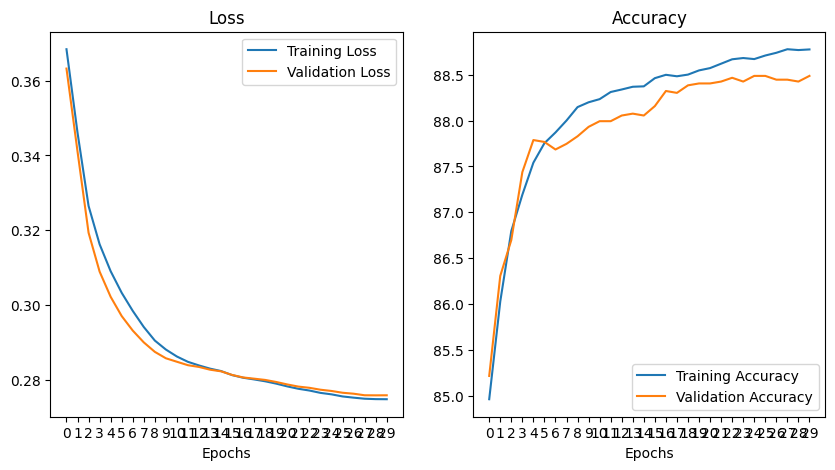

In [10]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in tqdm(range(epochs)):
  # training
  model.train()
  for i in range(0, len(xtrain_tensor), 1):
    inputs = xtrain_tensor[i:i+1]
    labels = ytrain_tensor[i:i+1]

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

  # log metrics
  model.eval()
  with torch.no_grad():
    train_outputs = model(xtrain_tensor)
    train_loss = criterion(train_outputs, ytrain_tensor)
    predicted = torch.round(train_outputs)
    train_accuracy = accuracy_score(predicted.detach().numpy(), ytrain_tensor.detach().numpy())*100

    val_outputs = model(xval_tensor)
    val_loss = criterion(val_outputs, yval_tensor)
    predicted = torch.round(val_outputs)
    val_accuracy = accuracy_score(predicted.detach().numpy(), yval_tensor.detach().numpy())*100

  train_losses.append(train_loss.item())
  val_losses.append(val_loss.item())
  train_accuracies.append(train_accuracy)
  val_accuracies.append(val_accuracy)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_losses, label='Training Loss')
ax[0].plot(val_losses, label='Validation Loss')
ax[0].set_xticks(np.arange(0, epochs, 1))
ax[0]. set_xlabel('Epochs')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(train_accuracies, label='Training Accuracy')
ax[1].plot(val_accuracies, label='Validation Accuracy')
ax[1].set_xticks(np.arange(0, epochs, 1))
ax[1]. set_xlabel('Epochs')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()

In [11]:
log_parameters()

pd.read_csv(f'{dataset}_Experiments.csv').sort_values(by='final_val_accuracy', ascending=False)

,epochs,learning_rate,weight_decay,model,final_train_loss,final_train_accuracy,final_val_loss,final_val_accuracy
1,20,0.0001,0.0001,"Sequential(\n (0): Conv2d(1, 2, kernel_size=(...",0.258403,89.550770,0.272967,89.126853
0,10,0.0001,0.0001,"Sequential(\n (0): Conv2d(1, 2, kernel_size=(...",0.282173,88.694876,0.286282,88.529654
5,30,0.0001,0.0001,"Sequential(\n (0): Conv2d(1, 2, kernel_size=(...",0.274739,88.777262,0.275792,88.488468
4,10,0.0001,0.0001,"Sequential(\n (0): Conv2d(1, 2, kernel_size=(...",0.288036,88.200563,0.285701,87.932455
2,20,0.0001,0.0001,"Sequential(\n (0): Conv2d(1, 3, kernel_size=(...",0.292401,88.433989,0.307772,87.623558
3,10,0.0010,0.0001,"Sequential(\n (0): Conv2d(1, 2, kernel_size=(...",0.543749,76.627686,0.543758,76.626853


## Pre-Trained Model & XGBoost

In [12]:
# # check how image looks like after resnet50 preprocessing
# x = train_dataset[0][0][0]
# plt.imshow(x, cmap='gray')
# plt.show()

# # resnet50 preprocessing
# preprocess = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[.5], std=[.5])
# ])

# # resnet50 preprocessing
# x = preprocess(x)
# plt.imshow(x[0], cmap='gray')
# plt.show()